In [ ]:
## Load Files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectorMixin
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.datasets import fetch_openml

## Warnings 
import warnings
warnings.filterwarnings('ignore')


In [2]:
class OutliersToMedianTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names=None):
        self.feature_names = feature_names
        self.bounds_ = {}

    def fit(self, X, y=None):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names)
        
        if self.feature_names:
             for col in self.feature_names:
                if col in X.columns:
                    Q1 = X[col].quantile(0.25)
                    Q3 = X[col].quantile(0.75)
                    IQR = Q3 - Q1
                    self.bounds_[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.feature_names)
        X_copy = X.copy()
        for col, (lower, upper) in self.bounds_.items():
            if col in X_copy.columns:
                mask = (X_copy[col] < lower) | (X_copy[col] > upper)
                X_copy.loc[mask, col] = np.nan
        return X_copy

class AdvancedFeatureSelector(BaseEstimator, SelectorMixin):
    def __init__(self, variance_percentile=0.10, corr_threshold=0.1, check_stability=True):
        self.variance_percentile = variance_percentile
        self.corr_threshold = corr_threshold
        self.check_stability = check_stability
        self.selected_indices_ = []
        self.n_features_in_ = 0

    def fit(self, X, y=None):
        X, y = check_X_y(X, y, accept_sparse=True)
        self.n_features_in_ = X.shape[1]
        df = pd.DataFrame(X)

        # 1. Variance
        variances = df.var()
        threshold = variances.quantile(self.variance_percentile)
        high_variance_mask = variances > threshold

        # 2. Correlation
        if y is not None:
            y_series = pd.Series(y).reset_index(drop=True)
            df_reset = df.reset_index(drop=True)
            correlations = df_reset.corrwith(y_series).abs().fillna(0)
            high_corr_mask = correlations > self.corr_threshold
        else:
            high_corr_mask = pd.Series([False] * len(df.columns))

        # 3. Stability
        stable_mask = pd.Series([True] * len(df.columns))
        if self.check_stability:
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            stability_scores = []
            for train_idx, _ in kf.split(df):
                split_var = df.iloc[train_idx].var()
                stability_scores.append(split_var)
            stability_df = pd.DataFrame(stability_scores)
            stability_std = stability_df.std()
            mean_std = stability_std.mean()
            if mean_std > 0:
                 stable_mask = stability_std < (mean_std * 2)

        final_mask = (high_variance_mask | high_corr_mask) & stable_mask
        self.selected_indices_ = np.where(final_mask)[0]
        
        if len(self.selected_indices_) == 0:
            self.selected_indices_ = np.arange(X.shape[1])
        return self

    def _get_support_mask(self):
        mask = np.zeros(self.n_features_in_, dtype=bool)
        mask[self.selected_indices_] = True
        return mask

In [3]:
## Load dataset temporary
df = fetch_openml(name="adult", version=2, as_frame=True).frame
target = "class"

In [4]:
## Dataset shape
df.shape

(48842, 15)

In [5]:
## check duplicate values
df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [6]:
## Check Datatype
df["class"] = (df["class"].map({
    "<=50K":0,
    ">50K":1
}).astype("int64"))

In [7]:
## Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48790 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48790 non-null  int64   
 1   workclass       45995 non-null  category
 2   fnlwgt          48790 non-null  int64   
 3   education       48790 non-null  category
 4   education-num   48790 non-null  int64   
 5   marital-status  48790 non-null  category
 6   occupation      45985 non-null  category
 7   relationship    48790 non-null  category
 8   race            48790 non-null  category
 9   sex             48790 non-null  category
 10  capital-gain    48790 non-null  int64   
 11  capital-loss    48790 non-null  int64   
 12  hours-per-week  48790 non-null  int64   
 13  native-country  47934 non-null  category
 14  class           48790 non-null  int64   
dtypes: category(8), int64(7)
memory usage: 3.4 MB


In [8]:
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1


In [9]:
df["class"].unique()

array([0, 1])

In [10]:
X = df.drop(df[["class"]], axis=1)
Y = df["class"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [11]:
numerical_col = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_col = X_train.select_dtypes(include='object').columns.tolist()

In [12]:
skewness = X_train[numerical_col].apply(lambda x: x.skew()).abs()
skew_threshold = 0.5

skewed_cols = skewness[skewness >= skew_threshold].index.tolist()
normal_cols = list(set(numerical_col) - set(skewed_cols))

In [13]:
skewed_cols

['age', 'fnlwgt', 'capital-gain', 'capital-loss']

<Figure size 1800x1400 with 0 Axes>

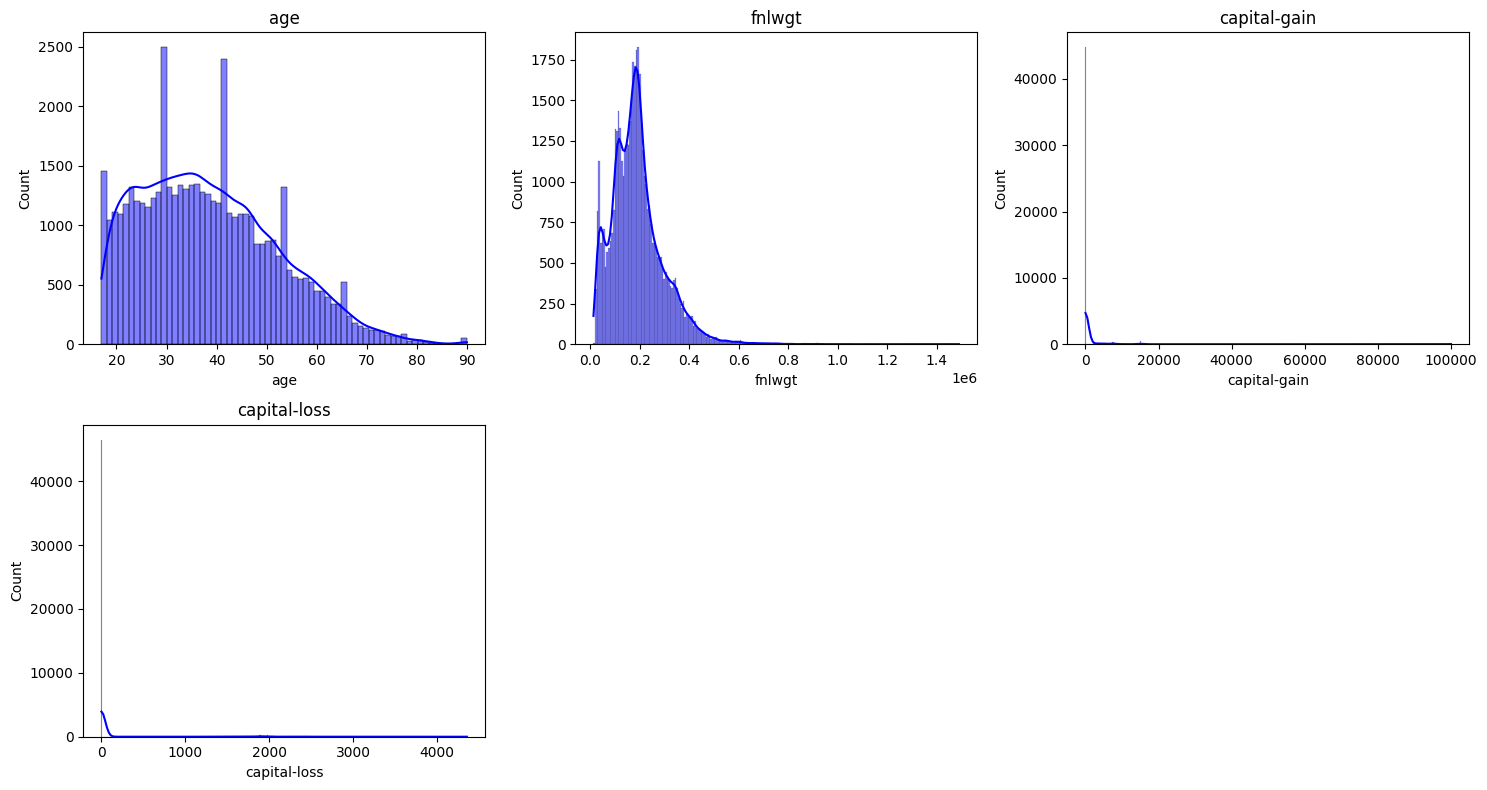

In [14]:
import math
plt.figure(figsize=(18, 14))
cols = df[skewed_cols].select_dtypes(include=np.number).columns
total = len(cols)
rows = math.ceil(total/3)
plt.figure(figsize=(15, rows* 4))

for i, col in enumerate(cols, 1):
    plt.subplot(rows, 3, i)
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(col)

plt.tight_layout()
plt.show()

In [15]:
## skew numerical processing 
skew_subpipe = Pipeline([
    ('outliers', OutliersToMedianTransformer(feature_names=skewed_cols)),
    ('imputer', SimpleImputer(strategy='median')),
    ('Transformer', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

In [16]:
## normal numerical processing
normal_subpipe = Pipeline([
    ('outliers', OutliersToMedianTransformer(feature_names=normal_cols)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

In [17]:
cat_subpipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('OneHotEncoding', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [18]:
preprocessor = ColumnTransformer([
    ('skew', skew_subpipe, skewed_cols),
    ('norm', normal_subpipe, normal_cols),
    ('cat', cat_subpipe, categorical_col)
], remainder='drop')

In [19]:
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', AdvancedFeatureSelector(variance_percentile=0.10, corr_threshold=0.05)),
    # ('model', LogisticRegression(class_weight='balanced'))
    ('Decision_Tree_Classifier', DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, max_features='sqrt', min_samples_split=20, max_leaf_nodes=30))
])

In [20]:
final_pipeline.fit(X_train, Y_train)

,steps,"[('preprocessor', ...), ('feature_selection', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('skew', ...), ('norm', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [21]:
final_pipeline.score(X_test, Y_test)*100

78.19225251076041

In [48]:
print("=== Training Base Model ===")
final_pipeline.fit(X_train, Y_train)
y_pred = final_pipeline.predict(X_test)
acc = accuracy_score(Y_test, y_pred)
print(f"Base Model Accuracy: {acc * 100:.2f}%")

=== Training Base Model ===
Base Model Accuracy: 78.19%


In [49]:
print("-" * 50)
print("Running Grid Search (This may take a moment)...")

param_grid = {
    'feature_selection__variance_percentile': [0.05, 0.10],
    'Decision_Tree_Classifier__max_depth': [10, 20, 30],
    'Decision_Tree_Classifier__min_samples_leaf': [10, 20],
    'Decision_Tree_Classifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    final_pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, Y_train)

print(f"\nBest Tuned Accuracy: {grid_search.best_score_ * 100:.2f}%")
print(f"Best Parameters: {grid_search.best_params_}")


--------------------------------------------------
Running Grid Search (This may take a moment)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Tuned Accuracy: 78.29%
Best Parameters: {'Decision_Tree_Classifier__criterion': 'gini', 'Decision_Tree_Classifier__max_depth': 10, 'Decision_Tree_Classifier__min_samples_leaf': 10, 'feature_selection__variance_percentile': 0.05}


--------------------------------------------------
Generating Heatmap...


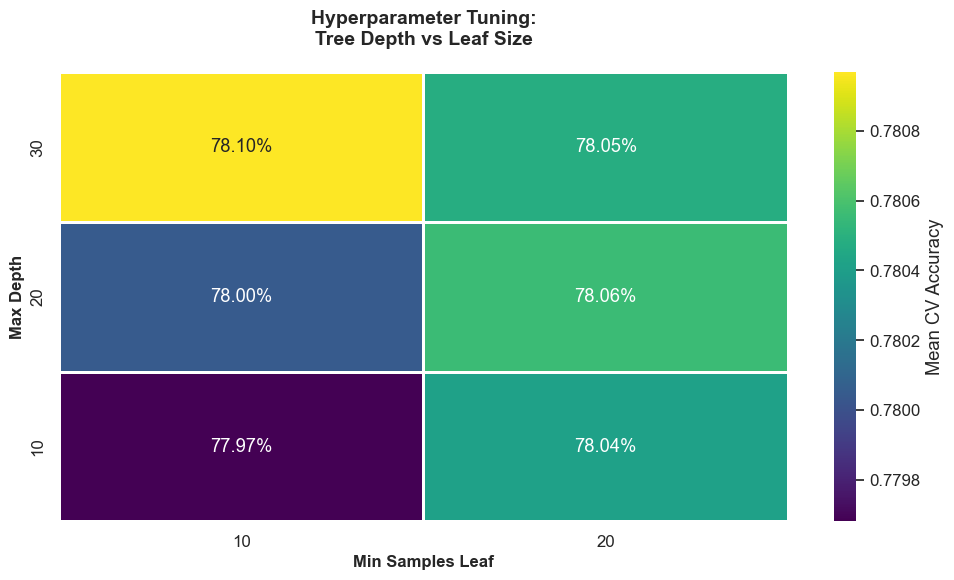

In [50]:
print("-" * 50)
print("Generating Heatmap...")

results_df = pd.DataFrame(grid_search.cv_results_)

# Grouping by Depth and Leaf to visualize 2D
heatmap_data = results_df.groupby([
    'param_Decision_Tree_Classifier__max_depth', 
    'param_Decision_Tree_Classifier__min_samples_leaf'
])['mean_test_score'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.set(font_scale=1.1)

sns.heatmap(
    heatmap_data,
    annot=True,            
    fmt=".2%",             
    cmap='viridis',        
    cbar_kws={'label': 'Mean CV Accuracy'},
    linewidths=1,          
    linecolor='white'
)

plt.title('Hyperparameter Tuning:\nTree Depth vs Leaf Size', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Min Samples Leaf', fontsize=12, fontweight='bold')
plt.ylabel('Max Depth', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

--------------------------------------------------
Running Grid Search (This may take a moment)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Tuned Accuracy: 78.29%
Best Parameters: {'Decision_Tree_Classifier__criterion': 'entropy', 'Decision_Tree_Classifier__max_depth': 20, 'Decision_Tree_Classifier__min_samples_leaf': 20, 'feature_selection__variance_percentile': 0.1}
--------------------------------------------------
Generating Heatmap...


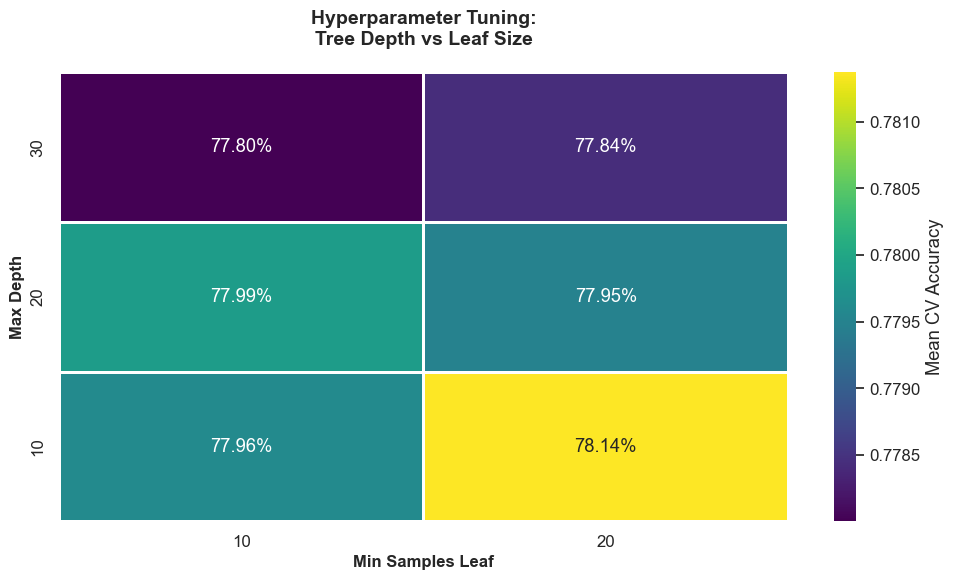

In [53]:
# Tuning
print("-" * 50)
print("Running Grid Search (This may take a moment)...")

param_grid = {
    'feature_selection__variance_percentile': [0.05, 0.10],
    'Decision_Tree_Classifier__max_depth': [10, 20, 30],
    'Decision_Tree_Classifier__min_samples_leaf': [10, 20],
    'Decision_Tree_Classifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    final_pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, Y_train)

print(f"\nBest Tuned Accuracy: {grid_search.best_score_ * 100:.2f}%")
print(f"Best Parameters: {grid_search.best_params_}")

## Visaulizing Heatmap
print("-" * 50)
print("Generating Heatmap...")

results_df = pd.DataFrame(grid_search.cv_results_)

# Grouping by Depth and Leaf to visualize 2D
heatmap_data = results_df.groupby([
    'param_Decision_Tree_Classifier__max_depth', 
    'param_Decision_Tree_Classifier__min_samples_leaf'
])['mean_test_score'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.set(font_scale=1.1)

sns.heatmap(
    heatmap_data,
    annot=True,            
    fmt=".2%",             
    cmap='viridis',        
    cbar_kws={'label': 'Mean CV Accuracy'},
    linewidths=1,          
    linecolor='white'
)

plt.title('Hyperparameter Tuning:\nTree Depth vs Leaf Size', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Min Samples Leaf', fontsize=12, fontweight='bold')
plt.ylabel('Max Depth', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()